In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer

In [33]:
df = pd.read_csv(r'C:\Users\Ксения\Project\Megy\validation\O_nan_for_val.csv')
df_val = pd.read_csv(r'C:\Users\Ксения\Project\Megy\validation\data_validation.csv')

In [34]:
id_m = df_val['MSIS num of ex']

In [35]:
df_val = df_val.drop(columns=['org_coating_HAcceptors', 'org_coating_LogP', 'MSIS num of ex'])

In [36]:
df = df.drop(columns=['org_coating_HAcceptors', 'org_coating_LogP'])

In [37]:
df_val = df_val.drop(columns=['id', 'сore_composition_formula'])

In [38]:
df = df.loc[:, 'area/volume':'mass_magnetic_susceptibility']

In [39]:
features = df.copy()
features = df.drop('saturation_magnetization', axis=1)
x = features.values
y = df.loc[:, ['saturation_magnetization']].values

In [40]:
y_val = df_val['saturation_magnetization'].values
x_val = df_val.drop(columns = ['saturation_magnetization'])

In [41]:
#splitting data using stratification procedure
y_discretized = KBinsDiscretizer(n_bins=5,
                                 encode='ordinal',
                                 strategy='uniform').fit_transform(y.reshape(-1, 1))
x_train, x_test, y_train, y_test = train_test_split(x, y.ravel(),
                                                  test_size=0.2,
                                                  random_state=10,
                                                  stratify=y_discretized)

c:\Users\Ксения\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


In [42]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
y_train = np.log10(y_train)
y_test = np.log10(y_test)
x_valid = scaler.transform(x_val)

c:\Users\Ксения\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [43]:
# Замена NaN значений средним значением столбца
y_train_mean = np.nanmean(y_train)
y_test_mean = np.nanmean(y_test)

y_train[np.isnan(y_train)] = y_train_mean
y_test[np.isnan(y_test)] = y_test_mean

In [44]:
if np.isnan(y_train).any() or np.isnan(y_test).any():
    print("NaN значения обнаружены в y_train или y_test")
else:
    print("NaN значения не обнаружены в y_train и y_test")

NaN значения не обнаружены в y_train и y_test


In [45]:
matplotlib.use('Agg')

In [46]:
#Machine Learning algorithm
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=300, max_depth=25,
                          min_samples_leaf=1, min_samples_split=2, random_state=1984)
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)
y1_pred = regressor.predict(x_train)
y_valid_predict = regressor.predict(x_valid)

In [47]:
#cross validation procedure
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

accuracy = cross_val_score(regressor, x_train, y_train, cv=5, scoring='r2')
accuracy1 = abs(cross_val_score(regressor, x_train, y_train, cv=5, scoring='neg_root_mean_squared_error'))
print("10-fold cross-validation (r2):", accuracy.mean())
print("10-fold cross-validation (RMSE):", abs(accuracy1.mean()))
# Получение предсказаний с помощью кросс-валидации
y_pred_cv = cross_val_predict(regressor, x_test, y_test, cv=10)
# Получение предсказаний для тренировочных данных
y_train_pred_cv = cross_val_predict(regressor, x_train, y_train, cv=10)
# Получение предсказаний для валидационных данных
y_valid_pred_cv = cross_val_predict(regressor, x_val, y_val, cv=10)

10-fold cross-validation (r2): 0.7130534405611574
10-fold cross-validation (RMSE): 0.15999685787715123


In [48]:
#accuracy of obtained model
from sklearn import metrics
print('r2_test:', metrics.r2_score(y_test, y_pred))
print('MAE_test:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE_test:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE_test:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('r2_train:', metrics.r2_score(y_train, y1_pred))
print('MAE_train:', metrics.mean_absolute_error(y_train, y1_pred))
print('MSE_train:', metrics.mean_squared_error(y_train, y1_pred))
print('RMSE_train:', np.sqrt(metrics.mean_squared_error(y_train, y1_pred)))

#plotting of results
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
f, ax = plt.subplots(figsize=(13, 10))
plt.scatter(y_train, y1_pred, color='#3a0170', s=70)
plt.scatter(y_test, y_pred, color='#b15fff', s=70)
plt.scatter(y_val, y_valid_predict, color='#FF0000', s=70)
plt.plot(y_test, y_test, color='gray')
ci = abs(accuracy1.mean())
x = np.linspace(-1, 4, 110)
ax.fill_between(x, (x-ci), (x+ci), color='b', alpha=.3)
plt.title('Random Forest predict saturation', size=30)
plt.xlabel('test data', fontsize=20)
plt.ylabel('predicted data', fontsize=20)
plt.tick_params(axis='both', labelsize=20)
plt.xlim(-1, 4)
plt.ylim(-1, 4)
plt.text(1, 0.2, f'RMSE cross-validation: {round(abs(accuracy1.mean()), 2)}', fontsize=25)
plt.text(1, -0.5, f'Mean difference between predicted and \ntrue values for validation samples: {round(abs(y_val - y_valid_predict).mean(), 2)}', fontsize=25)
plt.show()

r2_test: 0.8474473825834462
MAE_test: 0.03748951832358604
MSE_test: 0.008023204433715675
RMSE_test: 0.08957234190148025
r2_train: 0.9512403731846927
MAE_train: 0.021096924279026534
MSE_train: 0.0049199311330000274
RMSE_train: 0.07014222075896961


C:\Users\Ксения\AppData\Local\Temp\ipykernel_19488\1735939046.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [49]:
%matplotlib inline

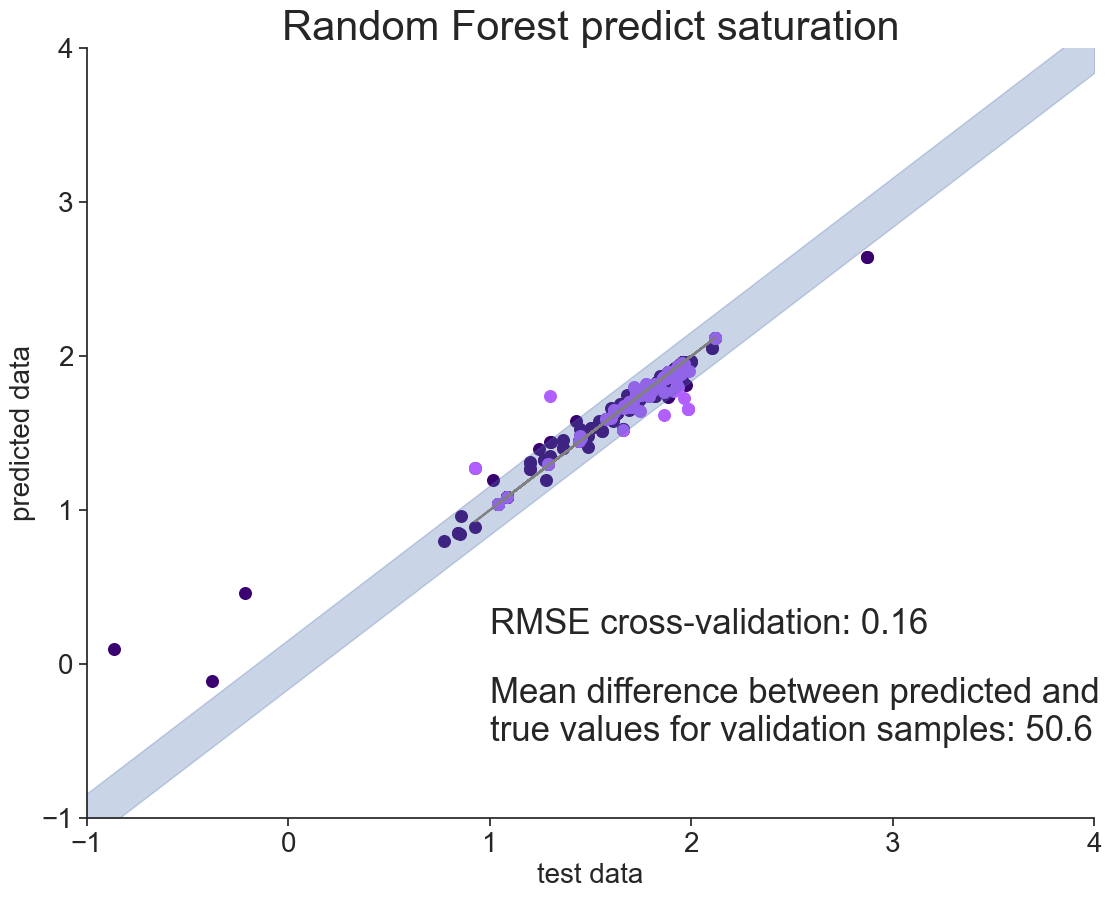

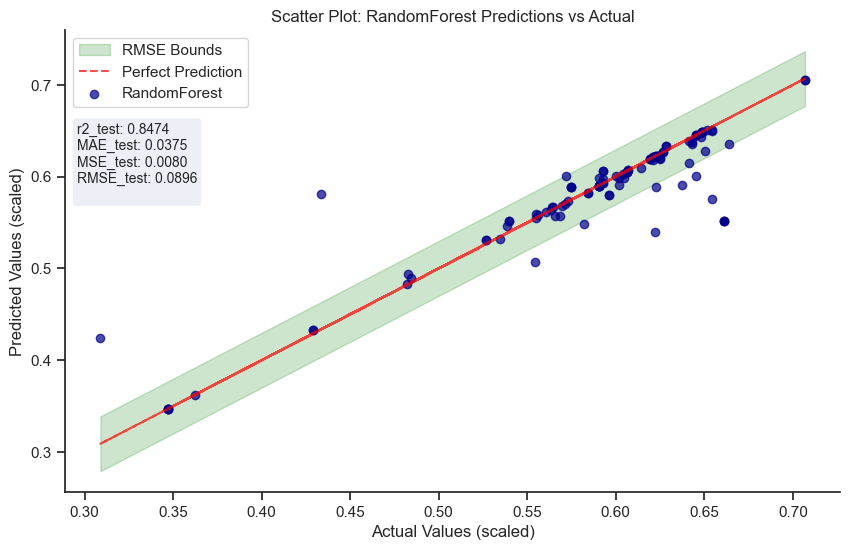

In [50]:
plt.figure(figsize=(10, 6))

# Уменьшение масштаба по оси Y для лучшей визуализации
y_test_scaled = y_test / 3
y_pred_scaled = y_pred / 3

# Линия разброса от линии идеального предсказания
lower_bound = np.sort(y_test_scaled - np.sqrt(metrics.mean_squared_error(y_test_scaled, y_pred_scaled)))
upper_bound = np.sort(y_test_scaled + np.sqrt(metrics.mean_squared_error(y_test_scaled, y_pred_scaled)))
plt.fill_between(np.sort(y_test_scaled), lower_bound, upper_bound, color='green', alpha=0.2, label='RMSE Bounds')

# Идеальная линия предсказания
plt.plot(y_test_scaled, y_test_scaled, label='Perfect Prediction', linestyle='--', color='red', alpha=0.7)

# Точки предсказаний
plt.scatter(y_test_scaled, y_pred_scaled, label='RandomForest', alpha=0.7, c='darkblue')

# Добавление текста с метриками
text_rf = f'r2_test: {metrics.r2_score(y_test, y_pred):.4f}\nMAE_test: {metrics.mean_absolute_error(y_test, y_pred):.4f}\nMSE_test: {metrics.mean_squared_error(y_test, y_pred):.4f}\nRMSE_test: {np.sqrt(metrics.mean_squared_error(y_test, y_pred)):.4f}\n'
plt.text(0.015, 0.8, text_rf, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))

plt.title('Scatter Plot: RandomForest Predictions vs Actual')
plt.xlabel('Actual Values (scaled)')
plt.ylabel('Predicted Values (scaled)')
plt.legend()
plt.show()

In [51]:
y_train_value = np.power(10, y_val)
y_test_value = np.power(10, y_valid_predict)
print(len(y_val), len(y_valid_predict), len(y_test_value))

df_predict = pd.DataFrame({'num_exp_MSIS': id_m, 'y_valid value real': y_val, 'y_valid_predict value': y_test_value, 'y_valid_predict after cv': y_valid_pred_cv})
print(df_predict)
# Создание DataFrame из двух колонок данных
df1 = pd.DataFrame({'y_test_value': y_test_value, 'y_valid_pred_cv': y_valid_pred_cv})

# Вывод DataFrame
print(df1)
df1.to_csv('result_predict_rf')

22 22 22
    num_exp_MSIS  y_valid value real  y_valid_predict value  \
0              2                80.3              29.492116   
1              3                66.3              52.310873   
2             10                35.2              52.372906   
3             11                45.3              52.566861   
4             13                99.3              51.510540   
5             14                36.6              52.013464   
6              5                76.8              50.629189   
7              6                58.5              51.040525   
8             15                28.8              51.436862   
9             16                26.5              50.893369   
10            17                20.3              50.758290   
11            18                46.1              50.858671   
12            19                19.7              50.690475   
13            20                26.8              51.179266   
14            21                31.0          